<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/210310_LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install / import / def

### 글꼴 설치

In [87]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


### import : for modeling
- MyChartPlotHistory(history)
- tensorflow, pandas, numpy, matplotlib, seaborn, keras

In [64]:
# from keras.datasets import fashion_mnist
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img    # keras 이미지 전처리를 위한 클래스

# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 는 tensorflow에 있는 데이터로만 가능
import os           # dir 읽어서 올림
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

import warnings
warnings.filterwarnings(action="ignore")

np.random.seed(121)
tf.random.set_seed(121)

In [65]:
def MyChartPlotHistory(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],    label='acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'val_acc')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],    label = 'loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'val_loss')
    plt.legend()
    plt.show()

### import: for map
- install pydeck, mip, geopandas
- sharply, geopandas

In [66]:
pip install pydeck

In [67]:
pip install mip

In [68]:
pip install geopandas

In [69]:
pip install rtree

In [70]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

# import pandas as pd
import geopandas as gpd
import folium
import shapely
import fiona
# import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sklearn.cluster
# import tensorflow as tf

#from geoband import API

import pydeck as pdk
import os

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'Nanum Gothic'
plt.rc('font', family='NanumBarunGothic') 

from shapely.geometry import Polygon, Point
from numpy import random

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

In [71]:
#Pydeck 사용을 위한 함수 정의
import geopandas as gpd 
import shapely # Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다. 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [72]:
def geo_to_df(df_whatwillread, na_col=None, norm_col=None, geotype='multipolygon'):

    # 격자별 인구 현황
    # df_08= gpd.read_file("../../data/GY/input/08.광양시_격자별인구현황(100X100).geojson")  --> df
    df_08 = df_whatwillread

    # val 열 na 제거
    if na_col != None:
      df_08[na_col] = df_08[na_col].fillna(0)


    # 인구 수 정규화
    if norm_col != None:
      df_08['정규화'] = df_08[norm_col] / df_08[norm_col].max()

    # geotype == 'multipolygon'
    if geotype == 'multipolygon':
      # geometry를 coordinate 형태로 적용
      df_08['coordinates'] = df_08['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type
    elif geotype == 'multilinestring':
      df_08['coordinates'] = df_08['geometry'].apply(line_string_to_coordinates) 
    elif geotype == 'polygon':
      df_08['coordinates'] = df_08['geometry'].apply(polygon_to_coordinates)
    elif geotype == 'multipoint':
      df_08['coordinates'] = df_08['geometry'].apply(multipoint_to_coordinates)        

    # 100X100 grid에서 central point 찾기
    df_08_list = []
    df_08_list2 = []
    for i in df_08['geometry']:
        cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
        df_08_list.append(cent)
        df_08_list2.append(Point(cent[0]))
    df_08['coord_cent'] = 0
    df_08['geo_cent'] = 0
    df_08['coord_cent']= pd.DataFrame(df_08_list) # pydeck을 위한 coordinate type
    df_08['geo_cent'] = df_08_list2               # geopandas를 위한 geometry type


    # 쉬운 분석을 위한 임의의 grid id 부여
    df_08['grid_id']=0
    idx = []
    for i in range(len(df_08)):
        idx.append(str(i).zfill(5))
    df_08['grid_id'] = pd.DataFrame(idx)

In [73]:
# for gpd plot
def gpdplot(dataframe, gpd_col, title="", show=True, cmap='YlGnBu_r', sub=False, nrow=None, ncol=None, figsize=(5, 5)):
    if sub == True:
        count=0
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        for r in range(nrow):
            if count > len(dataframe): break
            for c in range(ncol):
                if count >= len(dataframe): break
                ax = dataframe[count].plot(column=gpd_col[count], cmap=cmap, ax=axes[r,c])
                ax.set_title(title[count], fontsize=20)
                ax.set_axis_off()
                count += 1
                            
    else:
        ax = dataframe.plot(column=gpd_col, cmap=cmap, figsize=figsize)
        ax.set_title(title, fontsize=20)
        ax.set_axis_off()
    if show == True:
        plt.show()

## Data

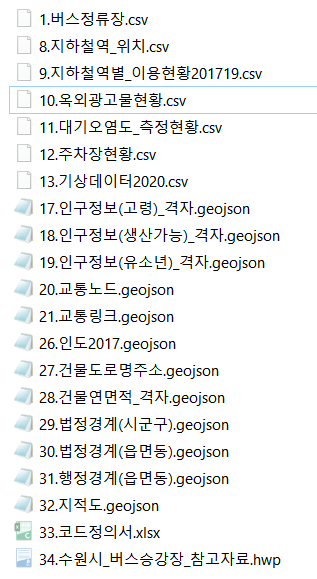
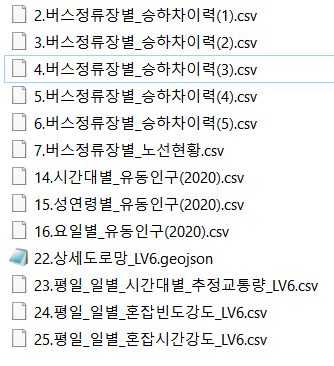

요일별 생략 가능 -> 시간대별 데이터 나눠서 사용


In [12]:
from google.colab import drive
drive.mount('/content/drive')
colab_path = '/content/drive/MyDrive/Colab Notebooks/data/LH/'
# colab_path = '/content/drive/MyDrive/data/LH/'

Mounted at /content/drive


### import data

In [13]:
gdf_인도   = gpd.read_file(colab_path + '26.인도2017.geojson', encoding='utf-8')
gdf_행정동 = gpd.read_file(colab_path + '31.행정경계(읍면동).geojson', encoding='utf-8')
gdf_지적도 = gpd.read_file(colab_path + '32.지적도.geojson', encoding='utf-8')
gdf_고령   = gpd.read_file(colab_path + '17.인구정보(고령)_격자.geojson', encoding='utf-8')
gdf_생산   = gpd.read_file(colab_path + '18.인구정보(생산가능)_격자.geojson', encoding='utf-8')
gdf_유소년 = gpd.read_file(colab_path + '19.인구정보(유소년)_격자.geojson', encoding='utf-8')

In [14]:
gdf_고령['label'] = '고령인구'
gdf_생산['label'] = '생산가능'
gdf_유소년['label'] = '유소년'

df_popul = []
df_popul = gdf_고령.append(gdf_생산)
df_popul = df_popul.append(gdf_유소년)

In [15]:
df_버스정류장 = pd.read_csv(colab_path + '1.버스정류장_mod(utf-8).csv', usecols=['정류장ID', '쉘터', 'BIS설치여부', 'lon', 'lat'])
df_노선현황   = pd.read_csv(colab_path + '7.버스정류장별_노선현황.csv')
df_대기오염   = pd.read_csv(colab_path + "11.대기오염도_측정현황_mod(utf-8).csv", usecols=['측정소', '미세먼지', '초미세먼지', 'lon', 'lat'])

In [16]:
df_유동인구_시간대 = pd.read_csv(colab_path + "14.시간대별_유동인구(2020).csv")
df_유동인구_요일별 = pd.read_csv(colab_path + "16.요일별_유동인구(2020).csv", names=["월","mon","tue","wed","thu","fri","sat","sun","lon","lat"], header=0)

성연령_names = ['월', '남10대', '남20대', '남30대', '남40대', '남50대', '남60대+', '여10대', '여20대', '여30대', '여40대', '여50대', '여60대+', 'lon', 'lat']
df_유동인구_성연령 = pd.read_csv(colab_path + "15.성연령별_유동인구(2020).csv", names=성연령_names, header=0)

In [17]:
df_1 = pd.read_csv(colab_path + '2.버스정류장별_승하차이력(1).csv', encoding='utf-8')
df_2 = pd.read_csv(colab_path + '3.버스정류장별_승하차이력(2).csv', encoding='utf-8')
df_3 = pd.read_csv(colab_path + '4.버스정류장별_승하차이력(3).csv', encoding='utf-8')
df_4 = pd.read_csv(colab_path + '5.버스정류장별_승하차이력(4).csv', encoding='utf-8')
df_5 = pd.read_csv(colab_path + '6.버스정류장별_승하차이력(5).csv', encoding='utf-8')

df_승하차이력 = df_1.append(df_2)
df_승하차이력 = df_승하차이력.append(df_3)
df_승하차이력 = df_승하차이력.append(df_4)
df_승하차이력 = df_승하차이력.append(df_5)

In [18]:
# df_상세도로망22 = gpd.read_file(colab_path + '22.상세도로망_LV6.geojson', encoding='utf-8')
# df_도로명27     = gpd.read_file(colab_path + '27.건물도로명주소.geojson', encoding='utf-8')
# df_연면적28     = gpd.read_file(colab_path + '28.건물연면적_격자.geojson', encoding='utf-8')
# df_법정시군구29 = gpd.read_file(colab_path + '29.법정경계(시군구).geojson', encoding='utf-8')
# df_법정읍면동30 = gpd.read_file(colab_path + '30.법정경계(읍면동).geojson', encoding='utf-8')
# df_교통노드20   = gpd.read_file(colab_path + '20.교통노드.geojson', encoding='utf-8')
# df_교통링크21   = gpd.read_file(colab_path + '21.교통링크.geojson', encoding='utf-8')

## From COMPAS

### EDA

####  <b>geojson</b> 풀기 for pydeck - type : multipolygon, multilinestring, multipoints
- 도로명27, 지적도32, 행정읍면동31, 법정시군구29, 법정읍면동30, 교통노드20, 교통링크21, 건물연면적28, 인도26
- 상세도로망22(비공개)

dataframe | type | ncols |columns 
-|-|-|-
df_교통노드20|multipoint|6|<b>NODE_ID</b>/ NODE_TYPE/ NODE_NAME/ TURN_P/ REMARK/ geometry
df_교통링크21|multilinestring|17|<b>LINK_ID</b>/ F_NODE/ T_NODE/ ROAD_USE/ LANES/ ROAD_RANK/ ROAD_NAME/ MULTI_LINK/ CONNECT/ MAX_SPD/ REST_VEH/ REST_W/ REST_H/ REMARK/ ROAD_TYPE/ ROAD_NO/<br> geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_인도26| multilinestring | 6 |<b>UFID</b>/ WIDT/ QUAL/ BYYN/ KIND/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_도로명27|multipolygon|11|<b>BDTYP_CD</b>/ BULD_NM/ BULD_NM_DC/ BULD_SE_CD/ BUL_MAN_NO/ EMD_CD/ GRO_FLO_CO/ LNBR_MNNM/ LNBR_SLNO/ UND_FLO_CO/ <br>geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_연면적28|multipolygon|3|<b>gid</b>/ val/ geometry/ 정규화/ coordinates/ coord_cent/ geo_cent/ grid_id
df_법정시군구29|multipolygon|3|<b>SIG_CD</b>/ SIG_KOR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_법정읍면동30|multipolygon|3|<b>EMD_CD</b>/ EMD_KOR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_행정읍면동31|multipolygon|3|<b>ADM_DR_CD</b>/ ADM_DR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_지적도32|multipolygon|3|<b>PNU</b>/ JIBUN/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
|<b>비공개 데이터</b>||
df_상세도로망22| multilinestring| 19 |<b>link_id</b>/ max_speed/ road_name/ road_no/ road_rank/ link_type/ road_type/ facil_name/ up_lanes/ dw_lanes/ oneway/ length/ width/ car_lane/ num_cross/ barrier/ up_its_id/ dw_its_id/ <br>geometry/ coordinates/ coord_cent/ geo_cent/ grid_id


In [19]:
# type: multipolygon
# geo_to_df(df_도로명27)
# geo_to_df(df_연면적28, na_col='val', norm_col='val')
# geo_to_df(df_법정시군구29)
# geo_to_df(df_법정읍면동30)

# geo_to_df(df_교통노드20)    # multipoint

# type: multilinestring
# geo_to_df(df_교통링크21, geotype='multilinestring')    # multilinestring
# geo_to_df(df_상세도로망22, geotype='multilinestring')  # multilinestring

In [20]:
# type: multipolygon
geo_to_df(gdf_행정동)
geo_to_df(gdf_지적도)

In [21]:
# type: multilinestring
geo_to_df(gdf_인도, geotype='multilinestring')        # multilinestring

In [22]:
geo_to_df(df_popul, norm_col='val') #, na_col='val'
# 인구 현황이 가장 높은 위치
# df_popul.iloc[df_popul["val"].sort_values(ascending=False).index].reindex().head()

#### <b>df_지적도32</b>: 도로, 공장, 학교, 주차장, 유원지, 체육시설

In [23]:
# for idx in range(df_지적도32.shape[0]):
#     df_지적도32['JIBUN'][idx] = df_지적도32['JIBUN'][idx][-1]

# df_지적도32.head(3)

In [24]:
# df_지적도32['JIBUN'].unique()

In [25]:
# jibun = ['도','장','학','차','원','체']
# df_지적도32 = df_지적도32[df_지적도32['JIBUN'].isin(jibun)]
# df_지적도32.info()

#### df_버정

In [26]:
df_버스정류장.head()

,정류장ID,쉘터,BIS설치여부,lon,lat
0,201000313,1.0,1.0,126.970983,37.256983
1,201000345,NaN,1.0,127.016000,37.251091
2,201000379,NaN,1.0,126.953845,37.268806
3,201000055,NaN,1.0,127.029815,37.256755
4,201000268,1.0,1.0,127.034254,37.246081


In [27]:
df_버스정류장 = df_버스정류장.fillna(0)
df_BIS = df_버스정류장[df_버스정류장['BIS설치여부'] == 1.0]
df_BIS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928 entries, 0 to 927
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    928 non-null    int64  
 1   쉘터       928 non-null    float64
 2   BIS설치여부  928 non-null    float64
 3   lon      928 non-null    float64
 4   lat      928 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 43.5 KB


#### <b>df_대기오염도</b>: 11.대기오염도_측정현황.csv
- 시각화: folium - 법정시군구별, 버스 정류장, 미세먼지 top 10

In [28]:
df_대기오염   = pd.read_csv(colab_path + "11.대기오염도_측정현황_mod(utf-8).csv", usecols=['측정소', '미세먼지', '초미세먼지', 'lon', 'lat'])
df_대기오염.info()

#설치전 null값 -> 0으로 처리
df_대기오염 = df_대기오염.fillna(0)
# df_대기오염.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정소     192 non-null    object 
 1   미세먼지    189 non-null    float64
 2   초미세먼지   189 non-null    float64
 3   lon     192 non-null    float64
 4   lat     192 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.6+ KB


In [29]:
def lonlat_to_point(dataframe):
    dataframe['point'] = None
    for idx in range(dataframe.shape[0]):
        dataframe['point'][idx] = [Point(dataframe['lon'][idx], dataframe['lat'][idx])]

    d_col = ['lon', 'lat']
    dataframe.drop(d_col, axis=1, inplace=True)

lonlat_to_point(df_대기오염)
df_대기오염.head()

,측정소,미세먼지,초미세먼지,point
0,고색동,62.0,41.0,[POINT (126.976384 37.252329)]
1,고색동,55.0,36.0,[POINT (126.976384 37.252329)]
2,고색동,66.0,47.0,[POINT (126.976384 37.252329)]
3,고색동,36.0,19.0,[POINT (126.976384 37.252329)]
4,고색동,43.0,25.0,[POINT (126.976384 37.252329)]


In [30]:
ap_place = {}
for n in range(len(df_대기오염.측정소.unique())):
    ap_place[df_대기오염.측정소.unique()[n]] = n

ap_place

{'고색동': 0,
 '광교동': 1,
 '동수원': 2,
 '신풍동': 3,
 '영통동': 4,
 '인계동': 5,
 '천천동': 6,
 '호매실동': 7}

In [31]:
df_대기오염['측정소'] = df_대기오염['측정소'].apply(lambda x : ap_place[x])
df_대기오염.head()

,측정소,미세먼지,초미세먼지,point
0,0,62.0,41.0,[POINT (126.976384 37.252329)]
1,0,55.0,36.0,[POINT (126.976384 37.252329)]
2,0,66.0,47.0,[POINT (126.976384 37.252329)]
3,0,36.0,19.0,[POINT (126.976384 37.252329)]
4,0,43.0,25.0,[POINT (126.976384 37.252329)]


In [32]:
df_대기오염 = df_대기오염.groupby('측정소').max().reset_index()
df_대기오염

,측정소,미세먼지,초미세먼지,point
0,0,66.0,47.0,[POINT (126.976384 37.252329)]
1,1,70.0,46.0,[POINT (127.070615 37.291321)]
2,2,89.0,54.0,[POINT (127.030494 37.276744)]
3,3,65.0,43.0,[POINT (127.010465 37.28385)]
4,4,71.0,41.0,[POINT (127.056294 37.246901)]
5,5,71.0,50.0,[POINT (127.028723 37.263637)]
6,6,73.0,49.0,[POINT (126.975305 37.292877)]
7,7,57.0,31.0,[POINT (126.957008 37.266153)]


In [34]:
col = ['미세먼지', '초미세먼지']

n_col = [i+'_mmsc' for i in col]

for i in range(len(col)):
    df_대기오염[n_col[i]] = df_대기오염[col[i]] / df_대기오염[col[i]].max()
df_대기오염

,측정소,미세먼지,초미세먼지,point,미세먼지_mmsc,초미세먼지_mmsc
0,0,66.0,47.0,[POINT (126.976384 37.252329)],0.741573,0.870370
1,1,70.0,46.0,[POINT (127.070615 37.291321)],0.786517,0.851852
2,2,89.0,54.0,[POINT (127.030494 37.276744)],1.000000,1.000000
3,3,65.0,43.0,[POINT (127.010465 37.28385)],0.730337,0.796296
4,4,71.0,41.0,[POINT (127.056294 37.246901)],0.797753,0.759259
5,5,71.0,50.0,[POINT (127.028723 37.263637)],0.797753,0.925926
6,6,73.0,49.0,[POINT (126.975305 37.292877)],0.820225,0.907407
7,7,57.0,31.0,[POINT (126.957008 37.266153)],0.640449,0.574074


In [35]:
from sklearn.preprocessing import MinMaxScaler

# 미세먼지, 초미세먼지 Normalization 최소값 0 / 최대값 1
scaler = MinMaxScaler()

colnames = ['미세먼지', '초미세먼지']

new_colnames = [i+'_mmsc' for i in colnames]

# z-score 스케일링을 한 데이터와 변형전 데이터 합친 dataframe
df_대기오염 = pd.concat([df_대기오염, pd.DataFrame(scaler.fit_transform(df_대기오염[colnames]), columns=new_colnames)], axis=1)
df_대기오염


,측정소,미세먼지,초미세먼지,point,미세먼지_mmsc,초미세먼지_mmsc,미세먼지_mmsc,초미세먼지_mmsc
0,0,66.0,47.0,[POINT (126.976384 37.252329)],0.741573,0.870370,0.28125,0.695652
1,1,70.0,46.0,[POINT (127.070615 37.291321)],0.786517,0.851852,0.40625,0.652174
2,2,89.0,54.0,[POINT (127.030494 37.276744)],1.000000,1.000000,1.00000,1.000000
3,3,65.0,43.0,[POINT (127.010465 37.28385)],0.730337,0.796296,0.25000,0.521739
4,4,71.0,41.0,[POINT (127.056294 37.246901)],0.797753,0.759259,0.43750,0.434783
5,5,71.0,50.0,[POINT (127.028723 37.263637)],0.797753,0.925926,0.43750,0.826087
6,6,73.0,49.0,[POINT (126.975305 37.292877)],0.820225,0.907407,0.50000,0.782609
7,7,57.0,31.0,[POINT (126.957008 37.266153)],0.640449,0.574074,0.00000,0.000000


#### <b>df_버스</b>: df_승하차이력 + df_버스정류장
- <b>df_승하차이력</b>: 버스정류장별 승하차이력(비공개, 2.~6.)
- <b>df_버스정류장</b>: 1.버스정류장 정보
- <b>df_노선현황</b>: 7.버스정류장별_노선현황(비공개)

In [36]:
df_승하차이력['전체 승차 건수'] = df_승하차이력['전체 승차 건수'].astype(np.int32)
df_승하차이력['초승 건수']      = df_승하차이력['초승 건수'].astype(np.int32)
df_승하차이력['환승 건수']      = df_승하차이력['환승 건수'].astype(np.int32)
df_승하차이력['전체 하차 건수'] = df_승하차이력['전체 하차 건수'].astype(np.int32)
df_승하차이력['하차 건수']      = df_승하차이력['하차 건수'].astype(np.int32)
df_승하차이력['미태그 건수']    = df_승하차이력['미태그 건수'].astype(np.int32)

In [37]:
df_승하차이력.drop('정류소명', axis=1, inplace=True)
df_승하차이력.drop('업체명', axis=1, inplace=True)

In [38]:
def busbus(bus):
    num = 0
    if   bus == '직행좌석형시내버스': num = 0
    elif bus == '일반형시내버스': num = 1
    elif bus == '경기순환버스(직행좌석형)' : num = 2
    elif bus == '광역급행형시내버스' : num = 3
    elif bus == '좌석형시내버스' : num = 4
    else: num = 5       # '맞춤형시내버스
    return num

In [39]:
df_승하차이력['노선유형'] = df_승하차이력['노선유형'].apply(lambda x : busbus(x))

In [40]:
features = ['정류소ID', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수', '하차 건수', '미태그 건수']
df_승하차 = df_승하차이력[features].groupby('정류소ID').agg(sum) 

df_승하차.reset_index(inplace=True)

In [41]:
승하차_col = {'정류소ID':'정류장ID', '전체 승차 건수':'전체승차', '초승 건수': '초승', '환승 건수':'환승', '전체 하차 건수':'전체하차', '하차 건수': '하차'}
df_승하차.rename(columns = 승하차_col, inplace = True)
# df_승하차.head()

In [42]:
df_버스 = df_승하차.merge(df_버스정류장, on='정류장ID', how="outer")

bs_col = ['정류장ID', '전체승차', '초승', '환승', '전체하차', '하차', '쉘터', 'BIS설치여부', 'lon', 'lat']
df_버스 = df_버스[bs_col]
df_버스.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1114 non-null   float64
 2   초승       1114 non-null   float64
 3   환승       1114 non-null   float64
 4   전체하차     1114 non-null   float64
 5   하차       1114 non-null   float64
 6   쉘터       1179 non-null   float64
 7   BIS설치여부  1179 non-null   float64
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 101.3 KB


In [43]:
# na값 채우기
df_버스 = df_버스.fillna(0)

# type 변경(float -> int)
for s in range(1, 8):
    df_버스[df_버스.columns[s]] = df_버스[df_버스.columns[s]].astype(np.int32)
df_버스.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1179 non-null   int32  
 2   초승       1179 non-null   int32  
 3   환승       1179 non-null   int32  
 4   전체하차     1179 non-null   int32  
 5   하차       1179 non-null   int32  
 6   쉘터       1179 non-null   int32  
 7   BIS설치여부  1179 non-null   int32  
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
dtypes: float64(2), int32(7), int64(1)
memory usage: 69.1 KB


In [44]:
# df_승하차이력['정류소ID'].nunique()     # 1114
# df_승하차이력['일자'].nunique()         # 2020-01-01 ~ 2020-12-31
# df_승하차이력['노선번호'].nunique()     # 156

In [45]:
노선_rename_col = {'정류소ID':'정류장ID', '중앙차로여부':'중앙차로노변', '위치(동)':'동'}
df_노선현황.rename(columns = 노선_rename_col, inplace=True)

df_노선현황 = df_노선현황[['정류장ID', '중앙차로노변', '동']]

In [46]:
df_노선현황.head()

,정류장ID,중앙차로노변,동
0,200000001,노변정류장,경기도 수원시 연무동
1,200000002,노변정류장,경기도 수원시 연무동
2,200000003,노변정류장,경기도 수원시 연무동
3,200000004,노변정류장,경기도 수원시 연무동
4,200000005,노변정류장,경기도 수원시 연무동


In [47]:
df_버스 = df_버스.merge(df_노선현황, on='정류장ID', how="outer")
df_버스.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1179 non-null   int32  
 2   초승       1179 non-null   int32  
 3   환승       1179 non-null   int32  
 4   전체하차     1179 non-null   int32  
 5   하차       1179 non-null   int32  
 6   쉘터       1179 non-null   int32  
 7   BIS설치여부  1179 non-null   int32  
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
 10  중앙차로노변   1128 non-null   object 
 11  동        1128 non-null   object 
dtypes: float64(2), int32(7), int64(1), object(2)
memory usage: 87.5+ KB


In [48]:
# df_버스['동'] = df_버스.동.str.split('경기도 수원시 ').str[1]
# df_버스.head()

In [49]:
df_버스['중앙차로노변'] = df_버스['중앙차로노변'].apply(lambda x: 0 if x == '노변정류장' else 1)
df_버스.head()

,정류장ID,전체승차,초승,환승,전체하차,하차,쉘터,BIS설치여부,lon,lat,중앙차로노변,동
0,200000001,533,529,4,3664,3664,0,0,127.016928,37.317630,0,경기도 수원시 연무동
1,200000002,978,971,7,18901,18901,0,0,127.019208,37.315958,0,경기도 수원시 연무동
2,200000003,2224,2180,44,10218,10218,0,0,127.021054,37.313257,0,경기도 수원시 연무동
3,200000004,3221,3087,134,14821,14821,0,0,127.027748,37.309108,0,경기도 수원시 연무동
4,200000005,9386,7970,1416,72860,72860,1,1,127.031546,37.301462,0,경기도 수원시 연무동


##### 되나 보자... contains! within!

In [50]:
# merge_버정 위치 좌표
mg_버정 = []
for mg in range(df_버스.shape[0]):
    temp = []
    temp = [df_버스['lon'][mg], df_버스['lat'][mg]]
    mg_버정.append(temp)

In [51]:
# 행정읍면동 위경도
center_point = {}
for idx in range(gdf_행정동.shape[0]):
    center_point[gdf_행정동['ADM_DR_NM'][idx]] = gdf_행정동['coord_cent'][idx]

In [52]:
from math import sqrt
def get_distance(array1, array2):
    return sqrt((array1[0] - array2[0]) ** 2 + (array1[1] - array2[1]) ** 2)

def src_to_ctr(search_point, map_point):      # mg_버정 인덱스 숫자
    search_list = []
    for idx, sp in enumerate(search_point):   # 1179
        dist = {}
        dist_list = {}
        search = {}
        for mp in range(len(map_point)):      # 44
            if len(dist) > 0:
                if min(sorted(list(dist.values()))) > get_distance(search_point[idx], list(center_point.values())[mp]):
                    dist[list(map_point.keys())[mp]] = get_distance(search_point[idx], list(map_point.values())[mp])
                    search[list(map_point.keys())[mp]] = {"dist_gap":dist[list(map_point.keys())[mp]], "정류장위치":search_point[idx]}
            else: 
                dist[list(map_point.keys())[mp]] = get_distance(search_point[idx], list(map_point.values())[mp])
                search[list(map_point.keys())[mp]] = {"dist_gap":dist[list(map_point.keys())[mp]], "정류장위치":search_point[idx]}
        dist_list[idx] = [search]
        search_list.append(dist_list)
    return search_list

In [53]:
src_list = src_to_ctr(mg_버정, center_point)
src_list[2]
# {2: [{'송죽동': 0.017620597279945947,
#    '연무동': 0.011546766545263142,
#    '정자2동': 0.03089267515984762,
#    '조원2동': 0.009081584111907352,
#    '파장동': 0.03250053355866013}]}

{2: [{'송죽동': {'dist_gap': 0.017620597279945947,
    '정류장위치': [127.02105390000001, 37.31325683]},
   '연무동': {'dist_gap': 0.011546766545263142,
    '정류장위치': [127.02105390000001, 37.31325683]},
   '정자2동': {'dist_gap': 0.03089267515984762,
    '정류장위치': [127.02105390000001, 37.31325683]},
   '조원2동': {'dist_gap': 0.009081584111907352,
    '정류장위치': [127.02105390000001, 37.31325683]},
   '파장동': {'dist_gap': 0.03250053355866013,
    '정류장위치': [127.02105390000001, 37.31325683]}}]}

#### <b>공간확보</b>: 4.0m이상 인도 + df_버스

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


<Figure size 1440x1440 with 0 Axes>

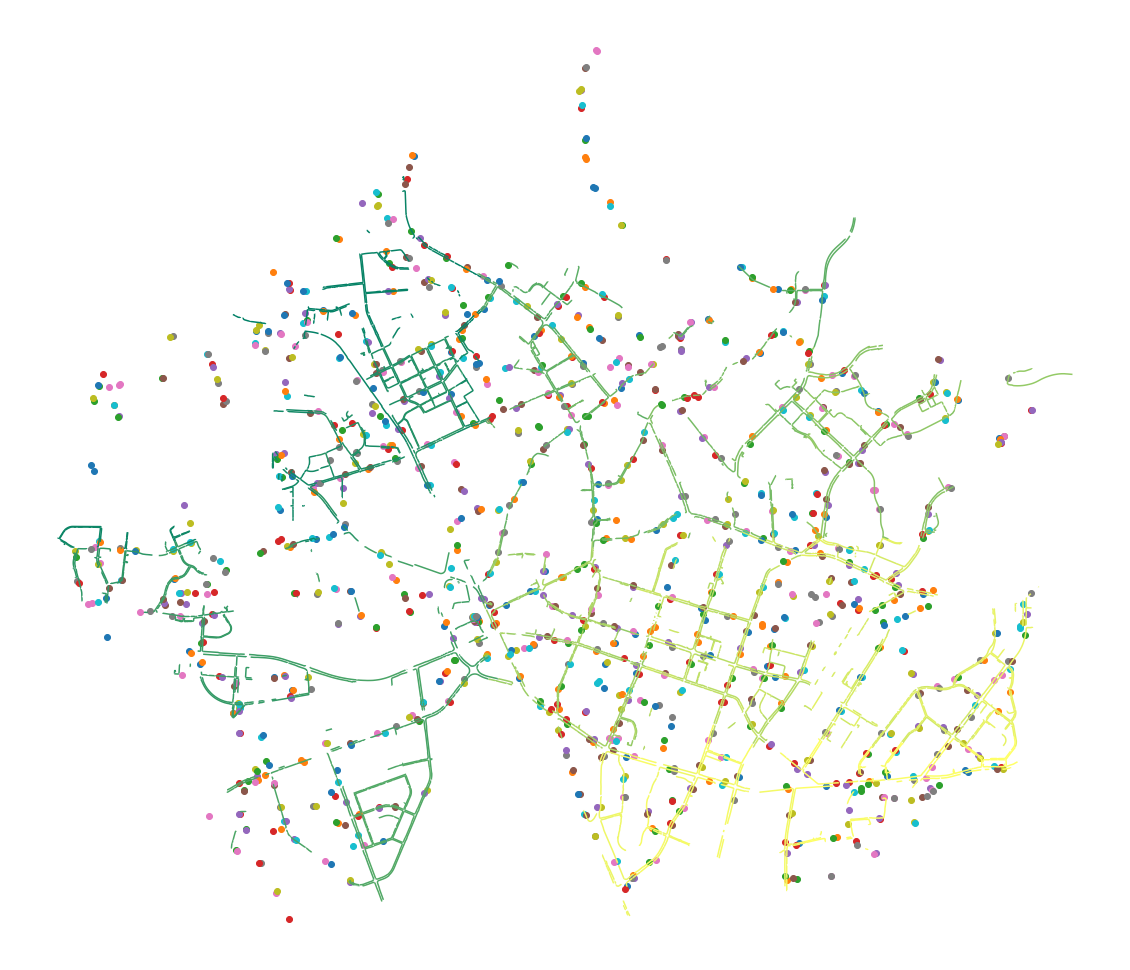

In [54]:
plt.figure(figsize=(20, 20))

ax1 = gdf_인도[gdf_인도['WIDT'] >= 4.0].plot(column = 'UFID', cmap='summer', figsize=(20, 20))
for idx in range(df_버스.shape[0]):
    plt.scatter(df_버스['lon'][idx], df_버스['lat'][idx])

ax1.set_axis_off()
plt.show()

#### <b>유동인구 데이터 탐색</b> - 혹시 비율로 시간대/요일별을 묶을 수 있을까?
- <b>df_유동인구_시간대_cate</b>: 새벽, 출근, 낮, 퇴근, 밤
- <b>df_유동인구_요일별_cate</b>: 평일, 주말
- <b>df_유동인구_성연령</b>

In [55]:
df_유동인구_성연령.head()

,월,남10대,남20대,남30대,남40대,남50대,남60대+,여10대,여20대,여30대,여40대,여50대,여60대+,lon,lat
0,202001,0.00,0.02,0.04,0.04,0.04,0.02,0.00,0.00,0.04,0.04,0.04,0.02,126.929668,37.270151
1,202001,0.06,0.08,0.06,0.10,0.09,0.08,0.06,0.06,0.07,0.12,0.09,0.10,126.930229,37.270604
2,202001,0.09,0.12,0.10,0.23,0.18,0.15,0.11,0.09,0.09,0.25,0.23,0.13,126.930188,37.276012
3,202001,0.04,0.04,0.04,0.08,0.06,0.02,0.04,0.04,0.04,0.08,0.06,0.02,126.931363,37.269708
4,202001,0.04,0.06,0.09,0.12,0.14,0.15,0.02,0.04,0.07,0.14,0.14,0.09,126.931319,37.275567


In [56]:


lonlat_to_point(df_유동인구_성연령)
df_유동인구_성연령.head(3)

KeyboardInterrupt: ignored

In [ ]:
# df_유동인구_요일별_cate
요일 = {'평일':['mon', 'tue', 'wed', 'thu', 'fri'],
        '주말':['sat', 'sun']}

for str in range(len(list(요일.keys()))):
    if len(list(요일.keys())) >= len(list(요일.values())[str]):
        for val in range(len(list(요일.values())[str])):
            df_유동인구_요일별['평일'] = df_유동인구_요일별[list(요일.values())[val]].agg(sum, axis=1) / 5
    else:
        for val in range(len(list(요일.values())[str])):
            df_유동인구_요일별['주말'] = df_유동인구_요일별[list(요일.values())[str]].agg(sum, axis=1) / 2

요일_col = ['월', '평일', '주말', 'lon', 'lat']
df_유동인구_요일별_cate = df_유동인구_요일별[요일_col]

lonlat_to_point(df_유동인구_요일별_cate)
df_유동인구_요일별_cate.head()

In [ ]:
colnames = ['미세먼지', '초미세먼지']

new_colnames = [i+'_mmsc' for i in colnames]

# z-score 스케일링을 한 데이터와 변형전 데이터 합친 dataframe
df_대기오염 = pd.concat([df_대기오염, pd.DataFrame(scaler.fit_transform(df_대기오염[colnames]), columns=new_colnames)], axis=1)
df_대기오염

In [ ]:
# df_유동인구_시간대_cate
시간 = {'새벽(01-05)':['TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05'], 
        '출근(06-09)':['TMST_06', 'TMST_07', 'TMST_08', 'TMST_09'], 
        '낮(10-16)'  :['TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16'], 
        '퇴근(17-20)':['TMST_17', 'TMST_18', 'TMST_19', 'TMST_20'], 
        '밤(21-00)'  :['TMST_21', 'TMST_22', 'TMST_23', 'TMST_00']}

for str in range(len(list(시간.keys()))):
    if len(list(시간.keys())) >= len(list(시간.values())[str]):
        for val in range(len(list(시간.values())[str])):
            df_유동인구_시간대[list(시간.keys())[val]] = df_유동인구_시간대[list(시간.values())[val]].agg(sum, axis=1)
    else:
        for val in range(len(list(시간.values())[str])):
            df_유동인구_시간대[list(시간.keys())[str]] = df_유동인구_시간대[list(시간.values())[str]].agg(sum, axis=1)

시간대_col = ['STD_YM', '새벽(01-05)', '출근(06-09)', '낮(10-16)', '퇴근(17-20)', '밤(21-00)', 'lon', 'lat']
df_유동인구_시간대_cate = df_유동인구_시간대[시간대_col]

df_유동인구_시간대_cate['월'] = df_유동인구_시간대_cate['STD_YM']
df_유동인구_시간대_cate.drop('STD_YM', axis=1, inplace=True)
df_유동인구_시간대_cate = df_유동인구_시간대_cate[['월', '새벽(01-05)', '출근(06-09)', '낮(10-16)', '퇴근(17-20)', '밤(21-00)', 'lon', 'lat']]

df_유동인구_시간대_cate.head()

#### folium - 버스정류장 + 인도 4.0m 이상

In [57]:
import folium
import json
import csv

from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon


def get_bus_stop_points():
    bsps = []
    bs_name = []

    # with open(colab_path + '1.버스정류장_mod(utf-8).csv') as bsf:
    #     reader = csv.reader(bsf)
    reader = df_버스

    for row in range(reader.shape[0]):
        # bsps.append([row[-1], row[-2]])
        bsps.append([reader['lon'][row], reader['lat'][row]])
        bs_name.append(reader['정류장ID'][row])

    return bs_name, list(map(lambda x: [float(x[0]), float(x[1])], bsps[1:]))


def get_sidewalk_polygons():
    with open(colab_path + '26.인도2017.geojson') as f:
        gj = json.loads(f.read())

    features = gj["features"]
    polygons = []

    for i in range(0, len(features)):
        if features[i]['properties']['WIDT'] >= 4.0:
            coordinates = features[i]["geometry"]["coordinates"]
            # polygons.append([[float(c[1]), float(c[0])] for cs in coordinates for c in cs])
            polygons.append([[float(c[0]), float(c[1])] for cs in coordinates for c in cs])

    return polygons

In [58]:
bus_stop_name, bus_stop_points = get_bus_stop_points()
sidewalk_polygons = get_sidewalk_polygons()

In [59]:
count = 0
res = []

for index, bsp in enumerate(bus_stop_points):
    bs_point = Point(bsp)

    for sps in sidewalk_polygons:
        if len(sps) == 2:
            s_poly = LineString(sps)

        else:
            s_poly = Polygon(sps)

        if s_poly.touches(bs_point) or s_poly.contains(bs_point):
            res.append([bs_point, sps])
            count += 1


    # print("{}/{}".format(index, len(bus_stop_points)))

print("4.0m(버스정류장 폭 2.5m + 인도 1.5m 폭)를 충족하는 버스 정류장 수: {}개" .format(count))

4.0m(버스정류장 폭 2.5m + 인도 1.5m 폭)를 충족하는 버스 정류장 수: 314개


In [60]:
for i in range(df_대기오염.shape[0]):
    aaa = (df_대기오염['미세먼지_mmsc'][i] + df_대기오염['초미세먼지_mmsc'][i]) / 2
    bbb = 0.01 * (1/aaa)
    ccc = 0.005 * aaa
    ddd = bbb - ccc
    print(aaa, "\t", ddd)

KeyError: ignored

In [ ]:
u_polygons - r_polygons


In [ ]:
from shapely.ops import cascaded_union
count = 0
ap_res = []
ap_polys_u = []
ap_polys_r = []

for i in range(df_대기오염.shape[0]):
    ap_value = (df_대기오염['미세먼지_mmsc'][i] + df_대기오염['초미세먼지_mmsc'][i]) / 2
    ap_poly_u = Polygon(df_대기오염['point'][i][0].buffer(0.02 * (1/ap_value)))
    ap_poly_r = Polygon(df_대기오염['point'][i][0].buffer(0.005 * ap_value))
    ap_polys_u.append(ap_poly_u)
    ap_polys_r.append(ap_poly_r)
        
    u_polygons = cascaded_union(ap_polys_u)
    r_polygons = cascaded_union(ap_polys_r)
    
polygons = Polygon(u_polygons - r_polygons)

for idx in range(len(res)):
    bs_point = res[idx][0]

    if polygons.touches(bs_point) or polygons.contains(bs_point):
        ap_res.append([bs_point])
        count += 1
        


print("4.0m를 충족하며, 측정소와 인접하지 않은 버스 정류장 수: {}개" .format(count))

In [83]:
center = (37.27505, 127.0094448)
zoom = 13

s_map = folium.Map(location=center, zoom_start=zoom, attr='수원시', 
                   tiles='cartodbpositron' )  #'http://api.vworld.kr/req/wmts/1.0.0/C475A102-4BC0-3992-8A8F-D9241A7B2094/Base/{z}/{y}/{x}.png')

sw_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

for i, r in enumerate(res):
    # folium.Polygon(locations=r[1], fill=False, tooltip="Polygon").add_to(s_map)
    poly = LineString(r[1])
    folium.GeoJson(poly, style_function=lambda x:sw_style).add_to(s_map)
    point = Point(r[0])
    folium.GeoJson(point).add_to(s_map)

s_map 
s_map.save("a.html")

In [74]:
center = (37.27505, 127.0094448)
zoom = 13

s_map = folium.Map(location=center, zoom_start=zoom, attr='수원시', 
                   tiles='cartodbpositron' )  #'http://api.vworld.kr/req/wmts/1.0.0/C475A102-4BC0-3992-8A8F-D9241A7B2094/Base/{z}/{y}/{x}.png')

bf_style = {'fillColor': '#e87a5477', 'color': '#e87a5477'}
ap_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

for i, r in enumerate(ap_res):
    point = Point(r[0])
    folium.GeoJson(point).add_to(s_map)


for ap in range(len(df_대기오염['point'])):
    folium.GeoJson(polygons, style_function=lambda x:bf_style).add_to(s_map)
    folium.GeoJson(df_대기오염['point'][ap][0].buffer(0.0001), style_function=lambda x:ap_style).add_to(s_map)
s_map #.save("a.html")

NameError: ignored

#### geopandas plot으로  확인 - gdpplot()

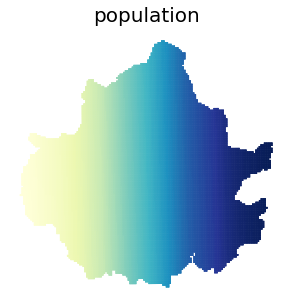

In [81]:
gpdplot(df_popul, "gid", title="population", cmap='YlGnBu')

In [62]:
gpdplot(df_인도26, "UFID", title="수원시 인도", cmap='summer', figsize=(8, 8))

NameError: ignored

In [ ]:
gpdplot(df_인도15up, "UFID", title="폭 1.5m이상 인도", cmap='summer', figsize=(8, 8))

In [ ]:
gpdplot(df_인도40up, "UFID", title="폭 4.0m이상 인도", cmap='summer', figsize=(8, 8))

In [ ]:
gpdplot(df_연면적28, 'gid', '건물연면적', figsize=(10, 10))

In [82]:
df_list  = [df_교통노드20, df_도로명27, df_지적도32, df_상세도로망22] #, df_교통링크21
df_ids   = ['NODE_ID', 'BDTYP_CD', 'PNU', 'link_id'] #, 'LINK_ID'
df_title = ['교통노드', '도로명', '지적도', '상세도로망'] #, '교통링크'

gpdplot(df_list, df_ids, title=df_title, sub=True, nrow=2, ncol=2, figsize=(15, 15))

NameError: ignored

In [ ]:
df_구역나눔_list  = [df_법정시군구29, df_법정읍면동30, df_행정읍면동31]
df_구역나눔_id    = ["SIG_CD", "EMD_CD", "ADM_DR_CD"]
df_구역나눔_title = ['법정시군구', '법정읍면동', '행정읍면동']

gpdplot(df_구역나눔_list, df_구역나눔_id, title=df_구역나눔_title, sub=True, nrow=2, ncol=2, figsize=(10, 10))

In [ ]:
# df_popul['geometry1'] = df_popul['geometry']
# df_popul['geometry'] = df_popul['geo_cent']

In [ ]:
# df_popul.head()

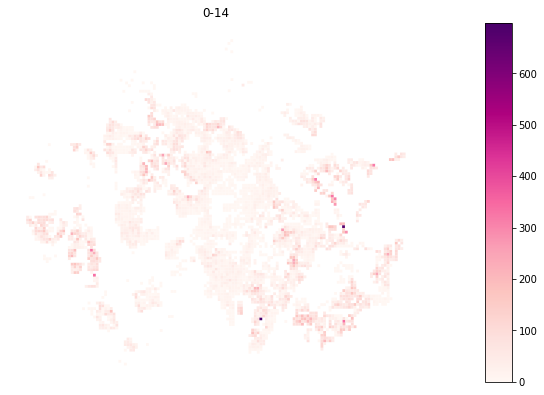

In [107]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 수원 시군구 인구 분포 단계구분도(Chropleth Map) 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# 시각화
column = 'val'
df_popul[df_popul['label'] == '유소년'].plot(column, ax=ax, legend=True, cax=cax, cmap='RdPu')
ax.set_title("0-14")
ax.set_axis_off()
plt.show()

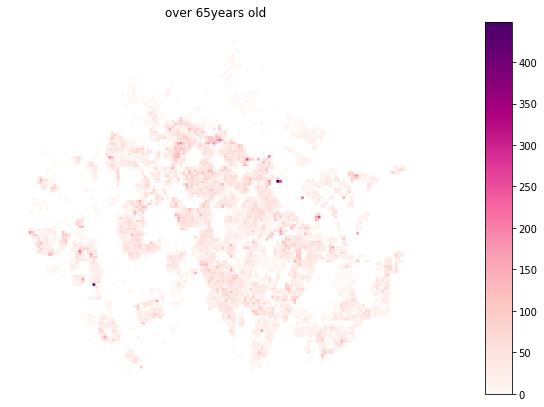

In [106]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 수원 시군구 인구 분포 단계구분도(Chropleth Map) 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# 시각화
column = 'val'
df_popul[df_popul['label'] == '고령인구'].plot(column, ax=ax, legend=True, cax=cax, cmap='RdPu')
ax.set_title("over 65years old")
ax.set_axis_off()
plt.show()

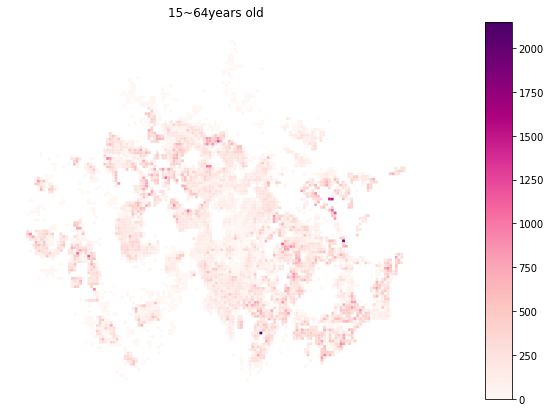

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 수원 시군구 인구 분포 단계구분도(Chropleth Map) 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# 시각화
column = 'val'
df_popul[df_popul['label'] == '생산가능'].plot(column, ax=ax, legend=True, cax=cax, cmap='RdPu')
ax.set_title("15~64years old")
ax.set_axis_off()
plt.show()

In [ ]:
df_행정읍면동31.head()

In [ ]:
# sigungu = 행정경계시군구.copy()
# dong = 고양시행정경계행정동기준.copy()
# sigungu['coordinates'] = sigungu['geometry'].apply(multipolygon_to_coordinates) 
# sigungu = pd.DataFrame(sigungu)

# dong['coordinates'] = dong['geometry'].apply(multipolygon_to_coordinates) 
# dong = pd.DataFrame(dong)
# dong['adm_nm'] = dong['행정동명']

In [ ]:
df_행정읍면동31['coord_cent'][0][0]

In [ ]:
# def get_point_isin_which_dong(Data_point_input, Data_dong_input, target):
#     Data_point = Data_point_input.copy()
#     Data_dong  = Data_dong_input.copy()
    
#     dong_contain = []
#     index = []
    
#     for i in tqdm(range(0, len(Data_point))):
#         for idx, coord in enumerate(Data_dong['geometry']):
            
#             if coord.contains(Point(Data_point[['경도','위도']].values[i])):
#                 dong_contain.append(Data_dong.loc[idx, target])           
#                 index.append(i)
                
#     return dong_contain, index

In [ ]:
# Data_point = df_popul
# Data_dong  = df_행정읍면동31

# dong_contain = []
# index = []

# for i in tqdm(range(0, len(Data_point))):
#     for idx, coord in enumerate(Data_dong['geometry']):
#         if coord.contains(Data_point[['coord_cent'][1], ['coord_cent'][0]].values[i]):
#             dong_contain.append(Data_dong.loc[idx, 'val'])           
#             index.append(i)

In [ ]:
# # 인구분포도 = 인구분포도[인구분포도['val'] != 0].reset_index(drop=True)
# df_popul = df_popul[df_popul['val'] != 0].reset_index(drop=True)

# print(len(df_popul))
# adm_nm, idx = get_point_isin_which_dong(df_popul, dong, 'adm_nm')

# # 인구분포도 = 인구분포도[인구분포도.index.isin(idx)]
# # 인구분포도['adm_nm'] = adm_nm
# df_popul = df_popul[df_popul.index.isin(idx)]
# df_popul['adm_nm'] = adm_nm

### 시각화 - pydeck ; Colab 작동 X(jupyter에서 사용)

In [ ]:
# # pydeck은 Colab 지원 X -> Jupyter notebook 사용
# # https://compas.lh.or.kr/subj/past/code?subjNo=SBJ_2009_001&teamNo=677
# # 광양시 전기자동차 충전소
# # Make layer
# # 사람이 있는 그리드만 추출
# layer = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
#                   df_popul[(df_popul['val'].isnull()==False) & df_popul['val']!=0], # 시각화에 쓰일 데이터프레임 
#                   get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
#                   get_fill_color='[0, 255*정규화인구, 0, 정규화인구*10000 ]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
#                   pickable=True, # 지도와 interactive 한 동작 on 
#                   auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
#                  ) 

# # Set the viewport location 
# center = [127.696280, 34.940640] 
# view_state = pdk.ViewState( 
#     longitude=center[0], 
#     latitude=center[1], 
#     zoom=10
# ) 

# # Render 
# r = pdk.Deck(layers=[layer], 
#              initial_view_state=view_state,
#              map_style='mapbox://styles/mapbox/dark-v9', 
#              api_keys='pk.eyJ1IjoianVuZ3dvbjY0MiIsImEiOiJja2x0aHYwc3UwM2hpMm5uNjF2cnRxMmlyIn0.f795wWCq-p1kAZBvoZL2Ww'
#             #  map_style='mapbox://styles/mapbox/outdoors-v11'
#             )
# # r = pdk.Deck(layers=[layer], initial_view_state=view_state)
# # r.to_html()

# r.show()

### 시각화 - folium; CircularBinning으로 json, to_crs, to_json

In [ ]:
# json = CircularBinning(features="geoband:gvi_busan", weight="greenview",
#                         csr="EPSG:4326", minX="128.7617", minY="34.9891", maxX="129.3056", maxY="35.389",
#                         radius="0.05", validGrid="False", saveFileName="json/result_CircularBinning.json")
# gdf = gpd.read_file('json/result_CircularBinning.json')

In [ ]:
# gdf = gdf.to_crs(epsg='4326')
# converted_json = gdf.to_json()

# m = folium.Map(
#     location=[35.1598,129.0001],
#     zoom_start=10
# )

# folium.GeoJson(
#     converted_json,
# ).add_to(m)

# m